In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [9]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [69]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_point[0], '%Y-%m-%d')
first_date = dt.date(last_date.year-1,last_date.month,last_date.day)
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= first_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(query, columns = ['Date','Precipitation'])
precipitation = precipitation.set_index('Date')
precipitation = precipitation.dropna()
# Sort the dataframe by date
precipitation = precipitation.sort_index()
precipitation
# Use Pandas Plotting with Matplotlib to plot the data


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


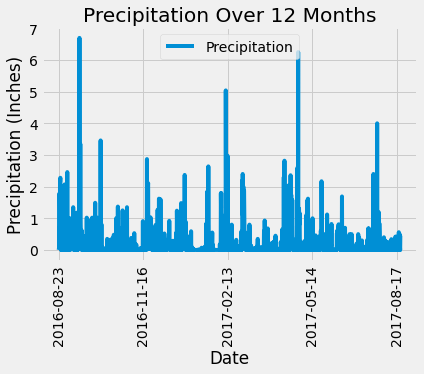

In [81]:
precipitation.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title("Precipitation Over 12 Months")
plt.legend(loc='upper center')

In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [83]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [16]:
stations = session.query(Measurement.station).group_by(Measurement.station).all() 

['USC00511918',
 'USC00513117',
 'USC00514830',
 'USC00516128',
 'USC00517948',
 'USC00518838',
 'USC00519281',
 'USC00519397',
 'USC00519523']

In [97]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_query = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
station_query.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [123]:
station_act = station_query.first()
station_act[0]

'USC00519281'

In [134]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_act = station_query.first()

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

temps = session.query(*sel).filter(Measurement.station == station_act[0])
tempe = temps.first()
print(f"The lowest temperature was {tempe[0]} degrees.")
print(f"The highest temperature was {tempe[1]} degrees.")
print(f"The average temperature was {round(tempe[2], 1)} degrees.")

The lowest temperature was 54.0 degrees.
The highest temperature was 85.0 degrees.
The average temperature was 71.7 degrees.


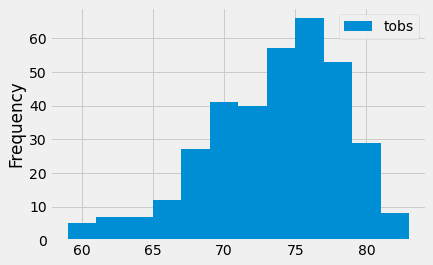

In [111]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).filter(Measurement.date >= first_date).filter(Measurement.station == station_act[0]).all()
tobs_df = pd.DataFrame(temp_obs)
tobs_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.title()

## Bonus Challenge Assignment

In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-03-22', '2018-03-22')

[(58.0, 76.31520532741398, 87.0)]

Text(0.5, 1.0, 'Trip Avg Temp')

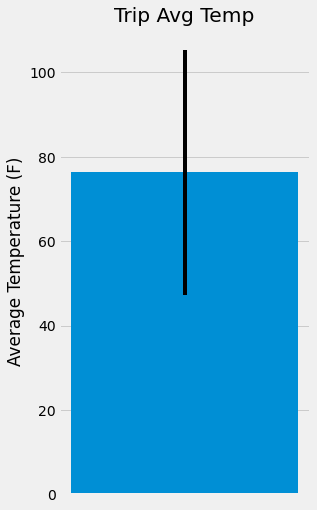

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_query = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= '2017-03-22').filter(Measurement.date <= '2018-03-22').all()
trip_df = pd.DataFrame(trip_query, columns = ['Minimum','Average','Maximum'])
tmax = trip_df['Maximum']
tmin = trip_df['Minimum']
tavg = trip_df['Average']
plt.figure(figsize=(4,8))
plt.bar(1,height=(tavg), yerr=tmax-tmin)
plt.xticks([])
plt.ylabel("Average Temperature (F)")
plt.title("Trip Avg Temp")

In [43]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_query = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.station==Station.station).filter(Measurement.date >= '2017-03-22').filter(Measurement.date <= '2018-03-22').group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_query

[('USC00516128',
  52.00000000000003,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  29.11999999999999,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  19.449999999999996,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  16.030000000000005,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  13.259999999999994,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  3.8299999999999983,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', 0.13, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [53]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [65]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2017-05-05"
end_date = "2017-05-12"
# Use the start and end date to create a range of dates
dates = pd.date_range(start=start_date,end=end_date)
# Stip off the year and save a list of %m-%d strings
date_list = [date.strftime('%m-%d') for date in dates]
# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normals = [daily_normals(date)[0] for date in date_list]
trip_normals

[(67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0),
 (67.0, 72.9322033898305, 79.0),
 (64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0)]

In [66]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals = pd.DataFrame(trip_normals, columns = ['Minimum','Average','Maximum'], index=dates)
normals

,Minimum,Average,Maximum
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0
2017-05-10,64.0,73.315789,78.0
2017-05-11,65.0,73.611111,79.0
2017-05-12,65.0,73.137931,79.0


Text(0, 0.5, 'Temperature (F)')

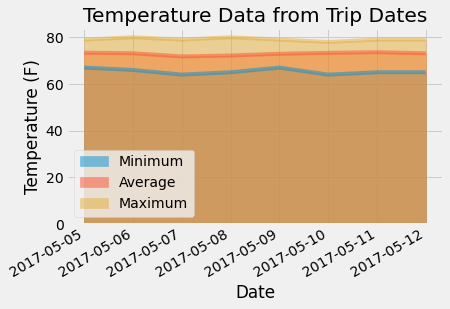

In [70]:
# Plot the daily normals as an area plot with `stacked=False`
normals.plot(kind="area", stacked=False, x_compat=True)
plt.title("Temperature Data from Trip Dates")
plt.xlabel("Date")
plt.ylabel("Temperature (F)")